In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE


# TRAIN_FILE_PATH = '/content/drive/My Drive/market_approvability_train.csv'
# TEST_FILE_PATH = '/content/drive/MyDrive/market_approvability_test.csv'

TRAIN_FILE_PATH = 'market_approvability_train.csv'
TEST_FILE_PATH = 'market_approvability_test.csv'

df_train = pd.read_csv(TRAIN_FILE_PATH, usecols=['smiles', 'label'])
smiles_train = df_train['smiles'].to_numpy()
labels_train = df_train['label'].to_numpy()
df_test = pd.read_csv(TEST_FILE_PATH, usecols=['smiles', 'label'])
smiles_test = df_test['smiles'].to_numpy()
labels_test = df_test['label'].to_numpy()

print(f"Loaded {len(smiles_train)} training SMILES, {len(smiles_test)} test SMILES.")

Loaded 8447 training SMILES, 939 test SMILES.


In [2]:
def tokenize_smiles(smiles, exclusive_tokens=None):
      """
      Tokenize a SMILES molecule at atom-level:
          (1) 'Br' and 'Cl' are two-character tokens
          (2) Symbols with bracket are considered as tokens

      exclusive_tokens: A list of specifical symbols with bracket you want to keep. e.g., ['[C@@H]', '[nH]'].
      Other symbols with bracket will be replaced by '[UNK]'. default is `None`.
      """

      pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"

      regex = re.compile(pattern)
      tokens = [token for token in regex.findall(smiles)]

      if exclusive_tokens:
          for i, tok in enumerate(tokens):
              if tok.startswith('['):
                  if tok not in exclusive_tokens:
                      tokens[i] = '[UNK]'

      return tokens

<>:11: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\['
C:\Users\berna\AppData\Local\Temp\ipykernel_18384\1511476010.py:11: SyntaxWarning: invalid escape sequence '\['
  pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"


In [3]:
# Tokenize train/test sets
tokenized_train = [tokenize_smiles(s) for s in smiles_train]
tokenized_test  = [tokenize_smiles(s) for s in smiles_test]

In [4]:
def build_vocab(tokenized_data):
    """
    Takes a list of token lists and builds:
      - token_to_idx: dict mapping token -> int
      - idx_to_token: dict mapping int -> token
    """
    token_freq = defaultdict(int)
    # print(token_freq)

    # Count frequencies across all SMILES
    for tokens in tokenized_data:
        for t in tokens:
            token_freq[t] += 1
    # print(token_freq)

    # Sort tokens by descending frequency
    sorted_tokens = sorted(token_freq.keys(), key=lambda x: -token_freq[x])

    token_to_idx = {}
    idx_to_token = {}

    for i, token in enumerate(sorted_tokens):
        token_to_idx[token] = i
        idx_to_token[i] = token

    return token_to_idx, idx_to_token

# Build vocab from the TRAIN set only
token_to_idx, idx_to_token = build_vocab(tokenized_train)
vocab_size = len(token_to_idx)

print(f"Vocab size = {vocab_size}")

print(token_to_idx)

Vocab size = 51
{'C': 0, 'c': 1, '(': 2, ')': 3, 'O': 4, '1': 5, '=': 6, '2': 7, 'N': 8, '[C@@H]': 9, '[C@H]': 10, '[n]': 11, '3': 12, '/': 13, 'F': 14, '4': 15, 'S': 16, '[C@]': 17, 'Cl': 18, '[C@@]': 19, '-': 20, '[nH]': 21, '\\': 22, '5': 23, '[N+]': 24, 'o': 25, '#': 26, '[s]': 27, '[O-]': 28, 'I': 29, 'P': 30, ':': 31, 'Br': 32, '[P@@]': 33, '[n+]': 34, '6': 35, '[P@]': 36, '[S@]': 37, '[S@@]': 38, '7': 39, '[N@@+]': 40, '8': 41, '[N@+]': 42, '0': 43, '9': 44, '[N-]': 45, '[S@@+]': 46, '[S@+]': 47, '[C-]': 48, '[s+]': 49, '[S+]': 50}


# 4. Create CBOW Pairs

In [5]:
def generate_cbow_samples(tokenized_data, token_to_idx, window_size=2):
    """
    Returns a list of (context_indices, target_index) pairs for CBOW.

    context_indices: list of integer token IDs around the target
    target_index   : integer token ID for the center token
    """
    cbow_samples = []
    for tokens in tokenized_data:
        indices = [token_to_idx[t] for t in tokens if t in token_to_idx]
        for i, target_idx in enumerate(indices):
            start = max(0, i - window_size)
            end   = min(len(indices), i + window_size + 1)

            # Gather neighbors (excluding the center token)
            context_list = []
            for j in range(start, end):
                if j != i:
                    context_list.append(indices[j])

            if len(context_list) == 0:
                continue

            # Add one sample: (list_of_context_tokens, target_token)
            cbow_samples.append((context_list, target_idx))

    return cbow_samples


def prepare_cbow_data(cbow_samples, max_context_size=4):
    """
    Convert (context_list, target) pairs to a NumPy array of shape:
      (num_samples, max_context_size + 1)
    We'll store:
      columns [0..max_context_size-1] => context tokens
      column  max_context_size        => target token
    We pad context lists that are shorter than max_context_size with 0.
    """
    data_rows = []
    for (ctx_list, tgt) in cbow_samples:
        # If context_list is bigger than max_context_size, truncate
        ctx = ctx_list[:max_context_size]
        # Pad if needed
        if len(ctx) < max_context_size:
            ctx += [0]*(max_context_size - len(ctx))
        # final row => [ctx_1, ctx_2, ..., ctx_N, target]
        data_rows.append(ctx + [tgt])
    return np.array(data_rows, dtype=np.int64)


In [6]:


cbow_samples_train = generate_cbow_samples(tokenized_train, token_to_idx, window_size=2)
max_context_size = 2*2  # since window_size=2 => 4 tokens
cbow_arr_train = prepare_cbow_data(cbow_samples_train, max_context_size=max_context_size)
print(f"cbow_arr_train shape = {cbow_arr_train.shape}")

cbow_arr_train shape = (389481, 5)


# 5. Define CBOW Model (with Negative Sampling)

In [7]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        """
        'input_embedding': for context tokens
        'output_embedding': for target (center) tokens
        """
        super(CBOWNegativeSampling, self).__init__()
        self.embedding_dim = embedding_dim

        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)   # for contexts
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)  # for targets

        # Initialize weights
        nn.init.xavier_uniform_(self.input_embedding.weight)
        nn.init.xavier_uniform_(self.output_embedding.weight)

    def forward(self, context_batch, target_batch, negative_batch):
        """
        context_batch: (batch_size, max_context_size)
        target_batch : (batch_size,)
        negative_batch: (batch_size, K)

        Returns:
          pos_score: (batch_size)   => dot(sum(context_emb), target_emb)
          neg_score: (batch_size,K) => dot(sum(context_emb), negative_emb_k)
        """
        # 1) Embed all context tokens => (batch_size, max_context_size, embedding_dim)
        context_emb = self.input_embedding(context_batch)

        # 2) Sum across context positions => (batch_size, embedding_dim)
        context_sum = torch.sum(context_emb, dim=1)

        # 3) Retrieve target embeddings => (batch_size, embedding_dim)
        target_emb = self.output_embedding(target_batch)

        # Positive score => dot(context_sum, target_emb)
        pos_score = torch.sum(context_sum * target_emb, dim=1)

        # Negative samples => shape => (batch_size, K, embedding_dim)
        neg_emb = self.output_embedding(negative_batch)

        # Expand context_sum => (batch_size, 1, embedding_dim)
        context_sum = context_sum.unsqueeze(1)

        # Dot product => (batch_size, K)
        neg_score = torch.sum(context_sum * neg_emb, dim=2)

        return pos_score, neg_score


def negative_sampling_loss(pos_score, neg_score):
    """
    Negative sampling loss:
      - Maximize log(sigmoid(pos_score))
      - Maximize log(sigmoid(-neg_score)) for negative samples
    """
    # pos_score: (batch_size)
    # neg_score: (batch_size, K)

    # Avoid log(0)
    eps = 1e-9

    # Positive part: log(sigmoid(pos_score))
    pos_loss = -torch.log(torch.sigmoid(pos_score) + eps)

    # Negative part: sum of log(sigmoid(-neg_score)) over K negative samples
    neg_loss = -torch.sum(torch.log(torch.sigmoid(-neg_score) + eps), dim=1)

    return torch.mean(pos_loss + neg_loss)

## Training the Model

In [8]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class CBOWDataset(Dataset):
    """
    Each row: [ctx_1, ctx_2, ..., ctx_n, target]
    """
    def __init__(self, data_arr):
        self.data = data_arr  # shape => (num_samples, max_context_size+1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        context = row[:-1]  # first max_context_size columns
        target  = row[-1]   # last column
        return context, target

# Hyperparameters



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



Using device: cuda


In [9]:
def train_cbow_model(
    model,
    data_loader,
    vocab_size,
    optimizer,
    loss_fn = None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device='cpu',
    plot=True
):
    print("Starting CBOW training...")
    total_start = time.time()
    losses = []

    dataset_size = len(data_loader.dataset)
    num_batches = dataset_size // batch_size

    for epoch in range(epochs):
        model.train()
        epoch_start = time.time()
        total_loss = 0.0

        for context, target in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            context = context.to(device)
            target = target.to(device)

            batch_size = context.size(0)
            neg_samples = np.random.choice(vocab_size, (batch_size, neg_sample_size), replace=True)
            neg_samples = torch.LongTensor(neg_samples).to(device)

            pos_score, neg_score = model(context, target, neg_samples)
            if loss_fn is None:
              loss = negative_sampling_loss(pos_score, neg_score)

            else:
              loss = loss_fn(pos_score, neg_score)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (num_batches or 1)
        losses.append(avg_loss)

        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

    total_time = time.time() - total_start
    print(f"\nTraining complete. Total time: {total_time:.2f}s for {epochs} epochs.")

    if plot:
        plt.plot(losses, marker='o')
        plt.xlabel("Epochs")
        plt.ylabel("Negative Sampling Loss")
        plt.title("CBOW Training Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return losses, total_time


epochs          = 5
batch_size      = 64
neg_sample_size = 5
learning_rate   = 0.01

cbow_train_dataset = CBOWDataset(cbow_arr_train)
cbow_train_loader = DataLoader(cbow_train_dataset, batch_size=batch_size, shuffle=True)

cbow_model_50 = CBOWNegativeSampling(vocab_size, 50).to(device)
optimizer_50  = optim.Adam(cbow_model_50.parameters(), lr=learning_rate)

cbow_model_100 = CBOWNegativeSampling(vocab_size, 100).to(device)
optimizer_100  = optim.Adam(cbow_model_100.parameters(), lr=learning_rate)

cbow_model_300 = CBOWNegativeSampling(vocab_size, 300).to(device)
optimizer_300  = optim.Adam(cbow_model_300.parameters(), lr=learning_rate)


cbow_model_512 = CBOWNegativeSampling(vocab_size, 512).to(device)
optimizer_512  = optim.Adam(cbow_model_512.parameters(), lr=learning_rate)


Starting CBOW training...


Epoch 1/5 | Avg Loss: 1.1697 | Time: 24.20s


Epoch 2/5 | Avg Loss: 1.1523 | Time: 28.11s


Epoch 3/5 | Avg Loss: 1.1469 | Time: 27.26s


Epoch 4/5 | Avg Loss: 1.1467 | Time: 27.24s


Epoch 5/5 | Avg Loss: 1.1463 | Time: 27.23s

Training complete. Total time: 134.04s for 5 epochs.


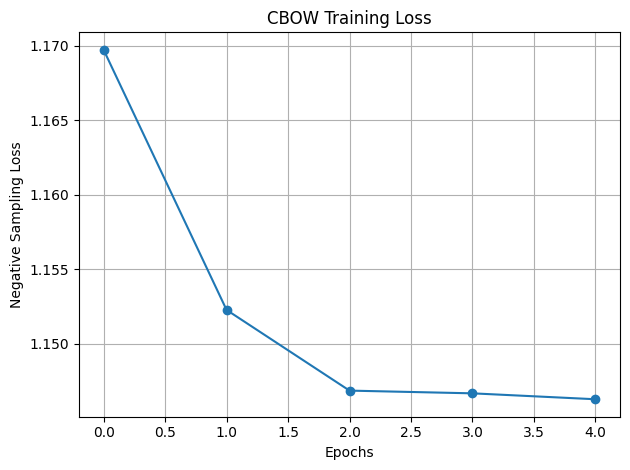

Starting CBOW training...


Epoch 1/5 | Avg Loss: 1.1790 | Time: 26.55s


Epoch 2/5 | Avg Loss: 1.1559 | Time: 25.11s


Epoch 3/5 | Avg Loss: 1.1527 | Time: 27.54s


Epoch 4/5 | Avg Loss: 1.1528 | Time: 27.49s


Epoch 5/5 | Avg Loss: 1.1509 | Time: 24.68s

Training complete. Total time: 131.38s for 5 epochs.


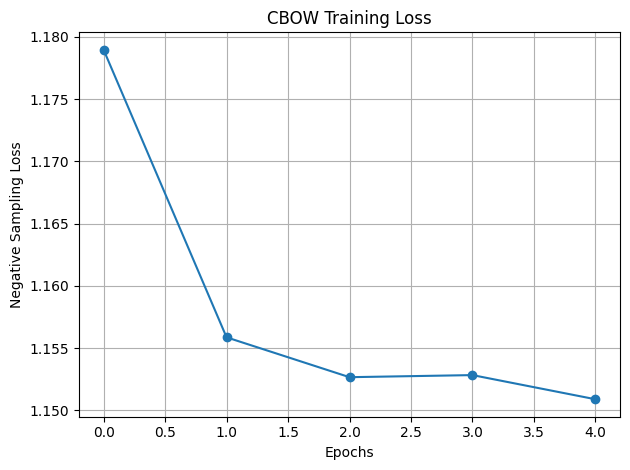

Starting CBOW training...


Epoch 1/5 | Avg Loss: 1.1933 | Time: 25.29s


Epoch 2/5 | Avg Loss: 1.1679 | Time: 24.19s


Epoch 3/5 | Avg Loss: 1.1662 | Time: 25.96s


Epoch 4/5 | Avg Loss: 1.1645 | Time: 25.64s


Epoch 5/5 | Avg Loss: 1.1665 | Time: 25.16s

Training complete. Total time: 126.24s for 5 epochs.


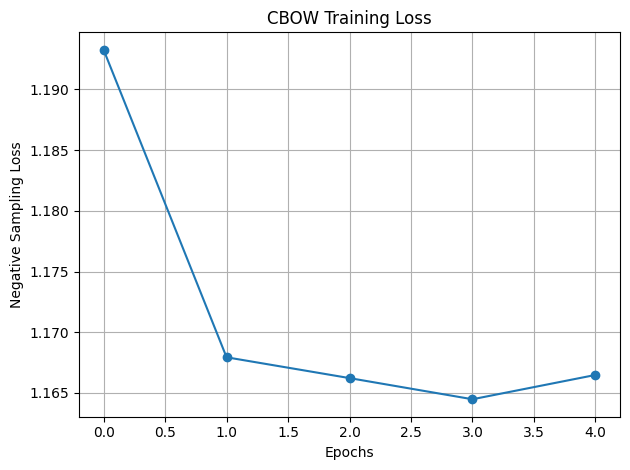

Starting CBOW training...


Epoch 1/5 | Avg Loss: 1.2045 | Time: 25.89s


Epoch 2/5 | Avg Loss: 1.1803 | Time: 26.01s


Epoch 3/5 | Avg Loss: 1.1783 | Time: 23.87s


Epoch 4/5 | Avg Loss: 1.1809 | Time: 24.74s


Epoch 5/5 | Avg Loss: 1.1790 | Time: 24.50s

Training complete. Total time: 125.01s for 5 epochs.


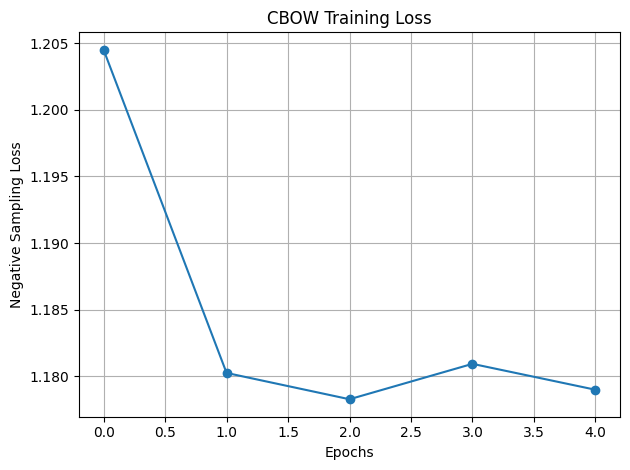

In [10]:
# Run trains for embed 50

meta_data_50 = train_cbow_model(
    cbow_model_50,
    cbow_train_loader,
    vocab_size,
    optimizer_50,
    loss_fn =None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device=device ,
    plot=True
)


# Run train for embed 100

meta_data_100 = train_cbow_model(
    cbow_model_100,
    cbow_train_loader,
    vocab_size,
    optimizer_100,
    loss_fn =None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device=device ,
    plot=True
)


# Run train for embed 300

meta_data_300 = train_cbow_model(
    cbow_model_300,
    cbow_train_loader,
    vocab_size,
    optimizer_300,
    loss_fn =None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device=device ,
    plot=True
)

meta_data_512 = train_cbow_model(
    cbow_model_512,
    cbow_train_loader,
    vocab_size,
    optimizer_512,
    loss_fn =None,
    neg_sample_size=5,
    epochs=5,
    batch_size=64,
    device=device ,
    plot=True
)

In [11]:
import pandas as pd



# Assume these are the second entries you want to collect
values_50 = meta_data_50[1]
values_100 = meta_data_100[1]
values_300 = meta_data_300[1]
values_512 = meta_data_512[1]

# Common parameters

# Construct rows as list of dicts
rows = [
    {"epoch": epochs, "dim": 50, "batch_size": batch_size, "value": values_50},
    {"epoch": epochs, "dim": 100, "batch_size": batch_size, "value": values_100},
    {"epoch": epochs, "dim": 300, "batch_size": batch_size, "value": values_300},
    {"epoch": epochs, "dim": 512, "batch_size": batch_size, "value": values_512}
]

# Create DataFrame
df = pd.DataFrame(rows)

# Optional: rename 'value' to something more specific
df.rename(columns={'value': 'total_time'}, inplace=True)

print("********** CBOW Model Training Time Summary *************")
display(df)


********** CBOW Model Training Time Summary *************


,epoch,dim,batch_size,total_time
0,5,50,64,134.044725
1,5,100,64,131.381269
2,5,300,64,126.243071
3,5,512,64,125.008544


#  Extract Word2Vec Embeddings

In [12]:
def smiles_to_embedding(smiles_str, model, token_to_idx):
    """
    Convert a SMILES string to a single embedding vector by
    averaging the 'input_embedding' (or 'output_embedding') for each token.
    """
    tokens = tokenize_smiles(smiles_str)
    vecs   = []
    for t in tokens:
        if t in token_to_idx:
            idx = token_to_idx[t]
            emb = model.input_embedding.weight[idx].detach().cpu().numpy()
            vecs.append(emb)

    if len(vecs) == 0:
        return np.zeros(model.embedding_dim)
    else:
        return np.mean(vecs, axis=0)


def get_all_embeddings(smiles_list, models, token_to_idx):
    """
    helper to aggregate them all embeddingsdings
    """
    all_embeddings = [[] for _ in models]

    for s in smiles_list:
        for i, model in enumerate(models):
            vec = smiles_to_embedding(s, model, token_to_idx)
            all_embeddings[i].append(vec)

    return [np.array(embed_list) for embed_list in all_embeddings]



models = [cbow_model_50, cbow_model_100, cbow_model_300, cbow_model_512]

train_embeddings_50, train_embeddings_100, train_embeddings_300, train_embeddings_512= get_all_embeddings(smiles_train, models, token_to_idx)
test_embeddings_50, test_embeddings_100, test_embeddings_300,  test_embeddings_512   = get_all_embeddings(smiles_test, models, token_to_idx)



## Major DRIVER CODE



<h2>1. Imports and Setup</h2>
<ul>
  <li>Imports libraries for:</li>
  <ul>
    <li><b>Numpy</b> - array and math operations.</li>
    <li><b>PyTorch</b> - building and training neural networks.</li>
    <li><b>scikit-learn</b> - splitting data and evaluating models.</li>
    <li><b>imblearn SMOTE</b> - oversampling minority classes to balance dataset.</li>
    <li><b>matplotlib</b> - plotting graphs.</li>
    <li><b>defaultdict</b> - organizing metrics conveniently.</li>
    <li><b>warnings</b> - to handle potential evaluation warnings.</li>
  </ul>
  <li>Sets device to GPU if available, otherwise CPU.</li>
</ul>

<h2>2. EmbeddingDataset Class</h2>
<ul>
  <li>A minimal PyTorch <code>Dataset</code> wrapper for embeddings and labels.</li>
  <li>Defines <code>__len__</code> to return dataset size.</li>
  <li>Defines <code>__getitem__</code> to return a tensor pair: embedding vector and label, both as float32 tensors.</li>
  <li>Enables easy batching and shuffling with PyTorch DataLoader.</li>
</ul>

<h2>3. ShallowMLP Model</h2>
<ul>
  <li>Simple feedforward neural network for binary classification.</li>
  <li>Input layer size matches embedding dimension.</li>
  <li>Architecture:</li>
  <ul>
    <li>Linear layer (input_dim → 128), ReLU activation, Dropout (10%)</li>
    <li>Linear layer (128 → 64), ReLU activation, Dropout (10%)</li>
    <li>Linear layer (64 → 1), Sigmoid activation (outputs probability)</li>
  </ul>
  <li>Output reshaped to 1D tensor for compatibility with loss functions.</li>
</ul>

<h2>4. run_shallow_mlp Function (Training with Early Stopping)</h2>
<ul>
  <li>Inputs: training, validation data loaders; optional test loader; training hyperparameters.</li>
  <li>Creates model, Adam optimizer, and binary cross-entropy loss.</li>
  <li>For each epoch:</li>
  <ul>
    <li>Trains model on training data, accumulating loss.</li>
    <li>Evaluates loss on validation data without gradient calculation.</li>
    <li>Tracks best validation loss and saves model state when improvement occurs.</li>
    <li>Implements early stopping: stops if no validation loss improvement after defined patience.</li>
  </ul>
  <li>Returns the model weights corresponding to best validation performance.</li>
</ul>

<h2>5. evaluate_model Function</h2>
<ul>
  <li>Runs the trained model on a dataset (usually test set) to get predictions.</li>
  <li>Collects predicted probabilities, predicted binary labels (threshold 0.5), and true labels.</li>
  <li>Calculates per-class metrics:</li>
  <ul>
    <li>Precision, Recall, F1-score, and ROC-AUC</li>
  </ul>
  <li>Generates ROC and Precision-Recall curves for each class.</li>
  <li>Uses <code>defaultdict</code> to store metrics neatly.</li>
  <li>Handles cases where a class has no positive samples by warning and skipping metrics.</li>
  <li>Returns the metrics and curve data for further analysis or plotting.</li>
</ul>

<h2>6. k_fold_cv Function (Cross-Validation Pipeline)</h2>
<ul>
  <li>Performs stratified k-fold cross-validation with optional SMOTE oversampling on training folds.</li>
  <li>For each fold:</li>
  <ul>
    <li>Splits embeddings and labels into training and testing sets.</li>
    <li>If SMOTE enabled, balances training data by oversampling minority classes.</li>
    <li>Further splits training set into training and validation subsets (80% train, 20% val) for early stopping.</li>
    <li>Creates PyTorch DataLoaders for train, val, and test sets.</li>
    <li>Trains ShallowMLP model with early stopping on train and val loaders.</li>
    <li>Evaluates trained model on test set, collecting metrics and curve data.</li>
  </ul>
  <li>Returns aggregated metrics and curve data from all folds.</li>
</ul>

<h2>7. analyze_results Function</h2>
<ul>
  <li>Computes average metric values (e.g., F1 score) across folds for a specific class.</li>
  <li>Calculates mean, standard deviation, and 95% confidence interval of scores.</li>
  <li>Prints summary statistics for easy interpretation.</li>
  <li>Returns the array of scores for further statistical analysis.</li>
</ul>

<h2>8. plot_roc_curves Function</h2>
<ul>
  <li>Plots ROC curves for a selected class across all cross-validation folds.</li>
  <li>Each fold’s ROC curve is plotted separately to visualize variability.</li>
  <li>Includes diagonal “chance” line for baseline comparison.</li>
  <li>Adds grid, axis labels, title, and legend for clarity.</li>
</ul>

<h3><b>Summary:</b></h3>
<p>This code implements a complete machine learning pipeline for classification on embedding data:</p>
<ul>
  <li>Data wrapped in a PyTorch Dataset for easy batching.</li>
  <li>Simple binary classifier neural net.</li>
  <li>Training with early stopping and validation monitoring.</li>
  <li>Robust evaluation with detailed per-class metrics and curves.</li>
  <li>Support for stratified k-fold cross-validation with optional SMOTE to address class imbalance.</li>
  <li>Tools for statistical analysis and visualization of results across folds.</li>
</ul>
<p>You can plug your data and run the pipeline to get statistically meaningful estimates of model performance. FOR SMOTE RE RUN PIPELINE WITH FLAG SET TO TRUE</p>


In [19]:
import numpy as np
import torch
import torch.nn as nn
import copy
import time
import warnings
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, classification_report
)
from imblearn.over_sampling import SMOTE
from collections import defaultdict


device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------------------
# Dataset wrapper for embedding data : Same as original
# ----------------------------------------
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        x = self.embeddings[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# ----------------------------------------
# Simple MLP for binary classification : same as original From saya's code
# ----------------------------------------
class ShallowMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)


# ----------------------------------------
# Train with early stopping : Original Code by Saya
# ----------------------------------------
def run_shallow_mlp(
    train_loader,
    val_loader,
    test_loader=None,
    epochs=50,
    lr=1e-3,
    patience=5,
    min_delta=1e-4,
    device=device,
    verbose=False  # <- PK EDIT: Added toggle for optional printing/plotting
):
    input_dim = train_loader.dataset[0][0].shape[0]
    model = ShallowMLP(input_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.BCELoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_state_dict = None
    epochs_no_improve = 0

    total_training_time_start = time.time()
    early_stop_epoch_time = None

    for ep in range(epochs):
        model.train()
        tloss = 0.0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs} [train]", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            loss = crit(model(xb), yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            tloss += loss.item() * xb.size(0)

        tloss /= len(train_loader.dataset)
        train_losses.append(tloss)

        # Validation pass
        model.eval()
        vloss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                vloss += crit(model(xb), yb).item() * xb.size(0)
        vloss /= len(val_loader.dataset)
        val_losses.append(vloss)

        #PK EDIT BEGINS
        if verbose:
            print(f"Epoch {ep+1:02d} | Train {tloss:.4f} | Val {vloss:.4f}")

        # Early stopping logic
        if vloss + min_delta < best_val_loss:
            best_val_loss = vloss
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stop at epoch {ep+1} (no val improvement for {patience} epochs).")
                early_stop_epoch_time = time.time()
                break

    # Restore best model weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Time reporting
    total_training_time_end = time.time()
    total_training_duration = total_training_time_end - total_training_time_start
    time_to_early_stop = (
        early_stop_epoch_time - total_training_time_start
        if early_stop_epoch_time
        else total_training_duration
    )

    if verbose:
        print(f"\n***** Total training time: {total_training_duration:.2f} seconds")
        if early_stop_epoch_time:
            print(f"Time until early stop: {time_to_early_stop:.2f} seconds (at epoch {ep+1})")

        # Plot training + val loss
        plt.figure(figsize=(7, 4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.axvline(len(train_losses) - epochs_no_improve - 1, linestyle="--", alpha=0.4, label="Best epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Shallow MLP – Training vs Validation Loss (early‑stopping)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "state_dict": model.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "model": model
    }

# ----------------------------------------
# Evaluate model and collect per-class metrics + ROC/PR curves
# ----------------------------------------
def evaluate_model_with_report(model, loader):
    model.eval()
    all_probs, all_preds, all_tgts = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            probs = model(xb).cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_tgts.extend(yb.numpy())

    y_true = np.array(all_tgts)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    # Generate detailed classification report (dict)
    report = classification_report(y_true, y_pred, output_dict=True)

    return report, y_true, y_prob


## PK EDITS : K CROSS VALIDATIONS
###
#Define standard scaler helper

def scale_fold_data(X_train, X_val, X_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_val_scaled, X_test_scaled




def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a = a[~np.isnan(a)]  # Remove NaNs
    if len(a) == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(len(a))
    h = sem * 1.96
    return mean, h

def analyze_results(fold_metrics, metric='f1-score', cls='0'):
    scores = [fold[cls][metric] for fold in fold_metrics if cls in fold and metric in fold[cls]]
    mean, ci95 = mean_confidence_interval(scores)
    print(f"{metric.upper()} (Class {cls}): {mean:.4f} ± {ci95:.4f}")
    return scores

def plot_roc_curves(curve_data, cls=1, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    for i, entry in enumerate(curve_data):
        if entry['class'] == cls:
            plt.plot(entry['fpr'], entry['tpr'], label=f"Fold {i+1}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f"{title} (Class {cls})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Main K-Fold CV with optional per-fold ROC
# ----------------------------------------

def stratified_fold_cv(
    embeddings,
    labels,
    X_test_ext,
    y_test_ext,
    smote=False,
    k=5,
    batch_size=64,
    seed=24,
    verbose=False,
    return_fold_roc=False,
    num_gpus=1,
    epochs = 30
):
    from time import time

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    all_reports = []
    all_y_true = []
    all_y_prob = []
    fold_roc_data = []

    print(f"\n@@@@@@@@ Running {k}-Fold Cross Validation with external test set @@@@@@@@\n")

    #  Start total timer
    start_all = time()

    for fold, (train_data_idx, val_data_idx) in enumerate(skf.split(embeddings, labels), 1):
        print(f"\n--- Fold {fold}/{k} ---")

        X_train_fold = embeddings[train_data_idx]
        y_train_fold = labels[train_data_idx]
        X_val_fold = embeddings[val_data_idx]
        y_val_fold = labels[val_data_idx]

        if smote:
            X_train_fold, y_train_fold = SMOTE(random_state=seed).fit_resample(X_train_fold, y_train_fold)

        # Scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        X_test_scaled = scaler.transform(X_test_ext)

        # Loaders
        train_loader = DataLoader(EmbeddingDataset(X_train_scaled, y_train_fold), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(EmbeddingDataset(X_val_scaled, y_val_fold), batch_size=batch_size)
        test_loader = DataLoader(EmbeddingDataset(X_test_scaled, y_test_ext), batch_size=batch_size)

        # Train model
        result = run_shallow_mlp(train_loader, val_loader, verbose=verbose, epochs = epochs)
        model = result["model"]
        model.load_state_dict(result["state_dict"])

        # Evaluate on external test set
        report, y_true_fold, y_prob_fold = evaluate_model_with_report(model, test_loader)

        print(f"\nClassification report for fold {fold}:\n")
        print(classification_report(y_true_fold, (y_prob_fold >= 0.5).astype(int)))

        all_reports.append(report)
        all_y_true.append(y_true_fold)
        all_y_prob.append(y_prob_fold)

        # Store ROC if requested
        if return_fold_roc:
            fpr, tpr, _ = roc_curve(y_true_fold, y_prob_fold)
            fold_roc_data.append({'class': 1, 'fpr': fpr, 'tpr': tpr})

    #  End total timer
    end_all = time()
    total_time_sec = end_all - start_all
    total_time_hr = total_time_sec / 3600
    total_gpu_hours = total_time_hr * num_gpus

    print(f"\n\n Total training time across {k} folds: {total_time_sec:.2f} seconds ({total_time_hr:.2f} hours)")
    print(f"Approximate GPU usage: {total_gpu_hours:.2f} GPU hours (using {num_gpus} GPU(s))\n")

    # --------------------
    # Aggregated Metrics
    # --------------------
    metric_keys = ['precision', 'recall', 'f1-score', 'support']
    aggregated_metrics = defaultdict(lambda: defaultdict(list))
    accuracies = []

    for report in all_reports:
        for cls_or_avg, metrics in report.items():
            if isinstance(metrics, dict):
                for metric_key in metric_keys:
                    if metric_key in metrics:
                        aggregated_metrics[cls_or_avg][metric_key].append(metrics[metric_key])
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])

    print("\nAggregated metrics across folds:\n")
    for cls_or_avg in aggregated_metrics.keys():
        print(f"Class/Average: {cls_or_avg}")
        for metric_key in metric_keys:
            vals = aggregated_metrics[cls_or_avg][metric_key]
            mean, ci95 = mean_confidence_interval(vals)
            print(f"  {metric_key}: {mean:.4f} ± {ci95:.4f}")
        print()

    if accuracies:
        mean_acc, ci95_acc = mean_confidence_interval(accuracies)
        print(f"Overall Accuracy: {mean_acc:.4f} ± {ci95_acc:.4f}")

    # --------------------
    # Aggregated ROC Curve
    # --------------------
    y_true_agg = np.concatenate(all_y_true)
    y_prob_agg = np.concatenate(all_y_prob)

    fpr, tpr, _ = roc_curve(y_true_agg, y_prob_agg)
    auc_score = roc_auc_score(y_true_agg, y_prob_agg)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Aggregated ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Aggregated ROC Curve Across All Folds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_reports, (y_true_agg, y_prob_agg), fold_roc_data if return_fold_roc else None, total_time_sec


# ----------------------------------------
# Analyze results: mean + 95% CI for a class: GPT generated
# ----------------------------------------
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a = a[~np.isnan(a)]  # Remove NaNs
    if len(a) == 0:
        return np.nan, np.nan
    mean = np.mean(a)
    sem = np.std(a, ddof=1) / np.sqrt(len(a))
    h = sem * 1.96
    return mean, h

def analyze_results(fold_metrics, metric='f1-score', cls='0'):
    # Try both string and int keys
    str_cls = str(cls)
    int_cls = int(cls) if isinstance(cls, str) and cls.isdigit() else None

    scores = []
    for fold in fold_metrics:
        if str_cls in fold and metric in fold[str_cls]:
            scores.append(fold[str_cls][metric])
        elif int_cls is not None and int_cls in fold and metric in fold[int_cls]:
            scores.append(fold[int_cls][metric])
    if not scores:
        print(f"No scores found for metric '{metric}' and class '{cls}'")
        return []
    mean, ci95 = mean_confidence_interval(scores)
    print(f"{metric.upper()} (Class {cls}): {mean:.4f} ± {ci95:.4f}")
    return scores

# ----------------------------------------
# Plot ROC for one class across folds : GPT generated
# ----------------------------------------

def analyze_accuracy(fold_metrics):
    accuracies = []
    for report in fold_metrics:
        if 'accuracy' in report:
            accuracies.append(report['accuracy'])
    if not accuracies:
        print("No accuracy scores found")
        return []
    mean, ci95 = mean_confidence_interval(accuracies)
    print(f"Accuracy: {mean:.4f} ± {ci95:.4f}")
    return accuracies



# ----------------------------------------
# Plot ROC for one class across folds : GPT generated
# ----------------------------------------

def plot_roc_curves(curve_data, cls=1, title='ROC Curve'):
    plt.figure(figsize=(8, 6))
    for i, entry in enumerate(curve_data):
        if entry['class'] == cls:
            plt.plot(entry['fpr'], entry['tpr'], label=f"Fold {i+1}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f"{title} (Class {cls})")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()






####### Processing 50D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.67      0.59      0.63       381
         1.0       0.74      0.80      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.69      0.70       939
weighted avg       0.71      0.72      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.68      0.56      0.62       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.71      0.50      0.59       381
         1.0       0.72      0.86      0.78       558

    accuracy                           0.71       939
   macro avg       0.71      0.68      0.68       939
weighted avg       0.71      0.71      0.70       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.68      0.54      0.61       381
         1.0       0.73      0.83      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.69      0.69       939
weighted avg       0.71      0.71      0.71       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.70      0.55      0.62       381
         1.0       0.73      0.84      0.78       558

    accuracy                           0.72       939
   macro avg       0.71      0.69      0.70       939
weighted avg       0.72      0.72      0.71       939



 Total training time across 5 folds: 49.12 seconds (0.01 hours)
Approximate GPU usage: 0.01 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6875 ± 0.0136
  recall: 0.5486 ± 0.0281
  f1-score: 0.6095 ± 0.0133
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7292 ± 0.0080
  recall: 0.8290 ± 0.0187
  f1-score: 0.7757 ± 0.0044
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7084 ± 0.0042
  recall: 0.6888 ± 0.0056
  f1-score: 0.6926 ± 0.0056
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7123 ± 0.0032
  recall: 0.7152 ± 0.

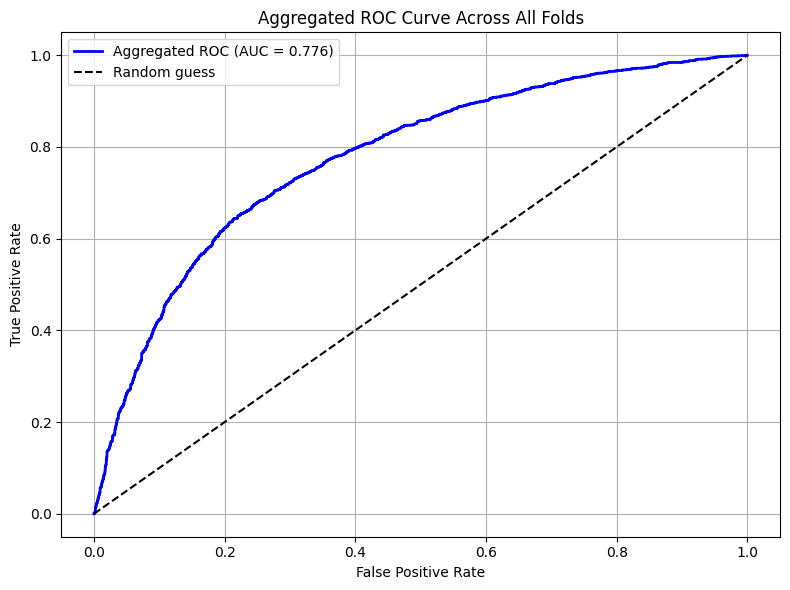

F1-SCORE (Class 0.0): 0.6095 ± 0.0133
F1-SCORE (Class 1.0): 0.7757 ± 0.0044
F1-SCORE (Class macro avg): 0.6926 ± 0.0056
Accuracy: 0.7152 ± 0.0030


####### Processing 100D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63       381
         1.0       0.74      0.79      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62       381
         1.0       0.74      0.77      0.75       558

    accuracy                           0.70       939
   macro avg       0.69      0.68      0.68       939
weighted avg       0.70      0.70      0.70       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.67      0.55      0.61       381
         1.0       0.73      0.82      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.68      0.69       939
weighted avg       0.70      0.71      0.70       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.66      0.49      0.56       381
         1.0       0.70      0.83      0.76       558

    accuracy                           0.69       939
   macro avg       0.68      0.66      0.66       939
weighted avg       0.69      0.69      0.68       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.50      0.57       381
         1.0       0.71      0.82      0.76       558

    accuracy                           0.69       939
   macro avg       0.68      0.66      0.66       939
weighted avg       0.68      0.69      0.68       939



 Total training time across 5 folds: 40.78 seconds (0.01 hours)
Approximate GPU usage: 0.01 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6563 ± 0.0106
  recall: 0.5475 ± 0.0457
  f1-score: 0.5958 ± 0.0270
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7231 ± 0.0159
  recall: 0.8039 ± 0.0203
  f1-score: 0.7610 ± 0.0057
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.6897 ± 0.0096
  recall: 0.6757 ± 0.0147
  f1-score: 0.6784 ± 0.0146
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.6960 ± 0.0104
  recall: 0.6999 ± 0.

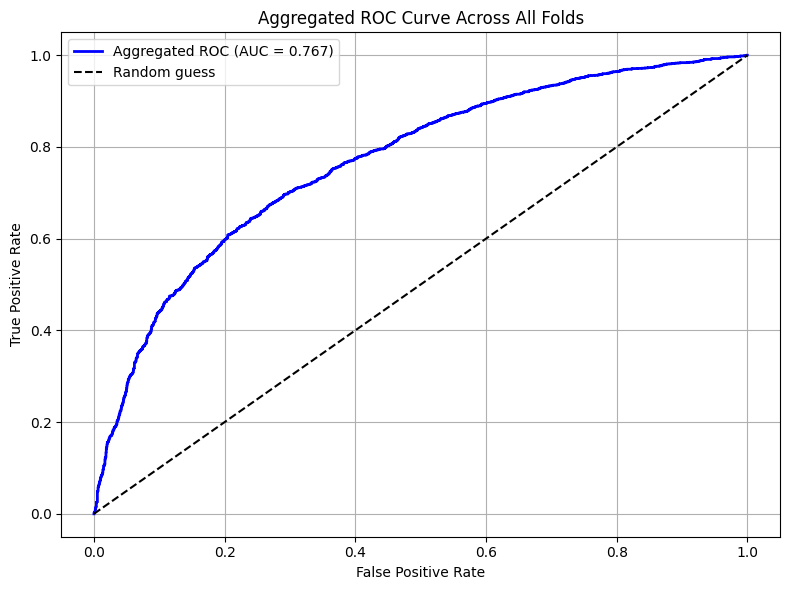

F1-SCORE (Class 0.0): 0.5958 ± 0.0270
F1-SCORE (Class 1.0): 0.7610 ± 0.0057
F1-SCORE (Class macro avg): 0.6784 ± 0.0146
Accuracy: 0.6999 ± 0.0097


####### Processing 300D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.66      0.53      0.59       381
         1.0       0.72      0.82      0.76       558

    accuracy                           0.70       939
   macro avg       0.69      0.67      0.67       939
weighted avg       0.69      0.70      0.69       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.68      0.48      0.56       381
         1.0       0.70      0.84      0.77       558

    accuracy                           0.70       939
   macro avg       0.69      0.66      0.66       939
weighted avg       0.69      0.70      0.68       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.64      0.52      0.57       381
         1.0       0.71      0.80      0.75       558

    accuracy                           0.68       939
   macro avg       0.67      0.66      0.66       939
weighted avg       0.68      0.68      0.68       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.56      0.61       381
         1.0       0.73      0.81      0.77       558

    accuracy                           0.71       939
   macro avg       0.70      0.68      0.69       939
weighted avg       0.70      0.71      0.70       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.51      0.57       381
         1.0       0.71      0.81      0.76       558

    accuracy                           0.69       939
   macro avg       0.68      0.66      0.66       939
weighted avg       0.68      0.69      0.68       939



 Total training time across 5 folds: 44.05 seconds (0.01 hours)
Approximate GPU usage: 0.01 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6582 ± 0.0140
  recall: 0.5186 ± 0.0243
  f1-score: 0.5797 ± 0.0153
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7130 ± 0.0083
  recall: 0.8158 ± 0.0151
  f1-score: 0.7608 ± 0.0064
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.6856 ± 0.0087
  recall: 0.6672 ± 0.0090
  f1-score: 0.6702 ± 0.0092
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.6908 ± 0.0081
  recall: 0.6952 ± 0.

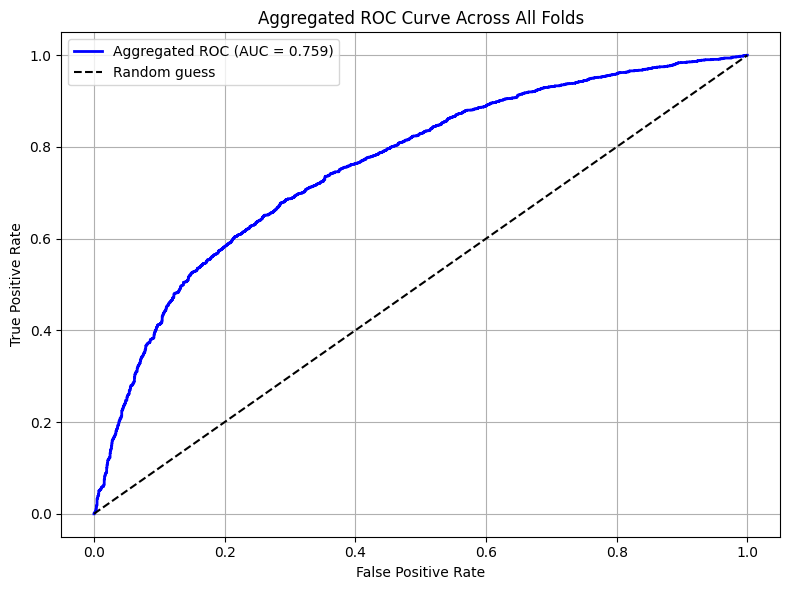

F1-SCORE (Class 0.0): 0.5797 ± 0.0153
F1-SCORE (Class 1.0): 0.7608 ± 0.0064
F1-SCORE (Class macro avg): 0.6702 ± 0.0092
Accuracy: 0.6952 ± 0.0076


####### Processing 512D without SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.63      0.60      0.62       381
         1.0       0.74      0.76      0.75       558

    accuracy                           0.70       939
   macro avg       0.69      0.68      0.68       939
weighted avg       0.70      0.70      0.70       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.65      0.59      0.62       381
         1.0       0.74      0.78      0.76       558

    accuracy                           0.71       939
   macro avg       0.69      0.69      0.69       939
weighted avg       0.70      0.71      0.70       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.66      0.50      0.57       381
         1.0       0.71      0.83      0.76       558

    accuracy                           0.69       939
   macro avg       0.68      0.66      0.67       939
weighted avg       0.69      0.69      0.68       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.67      0.53      0.59       381
         1.0       0.72      0.82      0.77       558

    accuracy                           0.70       939
   macro avg       0.70      0.68      0.68       939
weighted avg       0.70      0.70      0.70       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.64      0.57      0.60       381
         1.0       0.73      0.78      0.75       558

    accuracy                           0.70       939
   macro avg       0.68      0.68      0.68       939
weighted avg       0.69      0.70      0.69       939



 Total training time across 5 folds: 42.83 seconds (0.01 hours)
Approximate GPU usage: 0.01 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6517 ± 0.0128
  recall: 0.5575 ± 0.0366
  f1-score: 0.5999 ± 0.0177
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7253 ± 0.0109
  recall: 0.7957 ± 0.0235
  f1-score: 0.7585 ± 0.0060
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.6885 ± 0.0048
  recall: 0.6766 ± 0.0080
  f1-score: 0.6792 ± 0.0077
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.6954 ± 0.0048
  recall: 0.6990 ± 0.

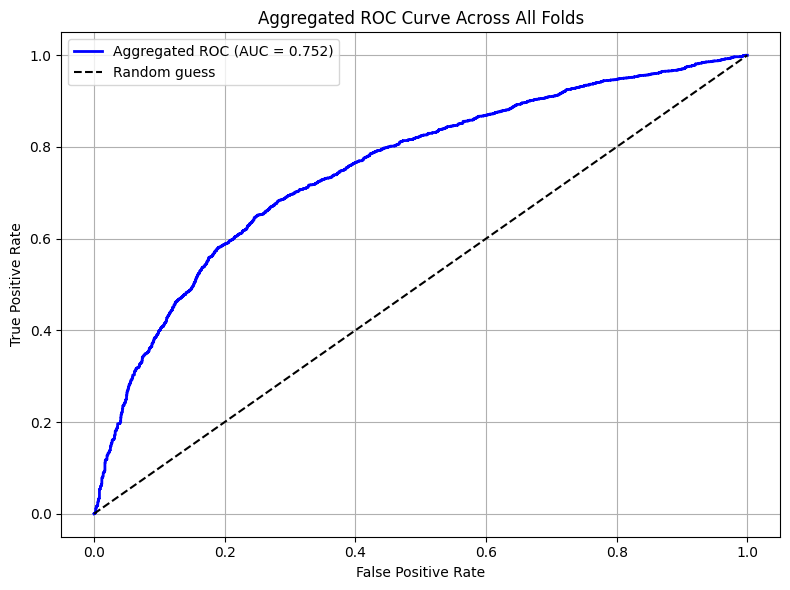

F1-SCORE (Class 0.0): 0.5999 ± 0.0177
F1-SCORE (Class 1.0): 0.7585 ± 0.0060
F1-SCORE (Class macro avg): 0.6792 ± 0.0077
Accuracy: 0.6990 ± 0.0046


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

embedding_dims = [50, 100, 300, 512]
results_summary = []
all_ytrue_yprob = {}  # For ROC/PR curves

# ---- Without SMOTE ----
for dim in embedding_dims:
    print(f"\n\n####### Processing {dim}D without SMOTE #######\n")
    X = np.array(eval(f"train_embeddings_{dim}"))
    y = np.array(labels_train)
    X_test_ext = np.array(eval(f"test_embeddings_{dim}"))
    y_test_ext = np.array(labels_test)

    reports, (y_true, y_prob), _, train_time = stratified_fold_cv(
        X, y, X_test_ext, y_test_ext,
        smote=False,
        k=5,
        verbose=False,
        return_fold_roc=True,
        num_gpus=1,
        epochs = 30
    )

    # Save for plotting
    all_ytrue_yprob[f"Dim {dim}"] = (y_true, y_prob)

    # Extract stats
    f1_0 = analyze_results(reports, metric='f1-score', cls=0.0)
    f1_1 = analyze_results(reports, metric='f1-score', cls=1.0)
    macro_f1 = analyze_results(reports, metric='f1-score', cls='macro avg')
    acc = analyze_accuracy(reports)
    auc_val = roc_auc_score(y_true, y_prob)
    
    results_summary.append({
        "Model": f"MLP ({dim}d)",
        "Accuracy": f"{np.mean(acc):.4f} ± {mean_confidence_interval(acc)[1]:.4f}",
        "F1_0": f"{np.mean(f1_0):.4f} ± {mean_confidence_interval(f1_0)[1]:.4f}",
        "F1_1": f"{np.mean(f1_1):.4f} ± {mean_confidence_interval(f1_1)[1]:.4f}",
        "Macro_F1": f"{np.mean(macro_f1):.4f} ± {mean_confidence_interval(macro_f1)[1]:.4f}",
        "ROC_AUC": f"{auc_val:.4f}",
        "Total Time (s)": f"{train_time:.4f}",
        "SMOTE": "No"
    })







####### Processing 50D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.64      0.69      0.66       381
         1.0       0.78      0.73      0.75       558

    accuracy                           0.71       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.71      0.72       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.64      0.61      0.63       381
         1.0       0.74      0.77      0.75       558

    accuracy                           0.70       939
   macro avg       0.69      0.69      0.69       939
weighted avg       0.70      0.70      0.70       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.66      0.63      0.65       381
         1.0       0.76      0.78      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.66      0.72      0.69       381
         1.0       0.80      0.75      0.77       558

    accuracy                           0.74       939
   macro avg       0.73      0.73      0.73       939
weighted avg       0.74      0.74      0.74       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.66      0.63      0.65       381
         1.0       0.76      0.78      0.77       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939



 Total training time across 5 folds: 62.94 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6533 ± 0.0120
  recall: 0.6562 ± 0.0393
  f1-score: 0.6541 ± 0.0205
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7652 ± 0.0179
  recall: 0.7620 ± 0.0189
  f1-score: 0.7632 ± 0.0083
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7092 ± 0.0118
  recall: 0.7091 ± 0.0143
  f1-score: 0.7086 ± 0.0128
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7198 ± 0.0126
  recall: 0.7191 ± 0.

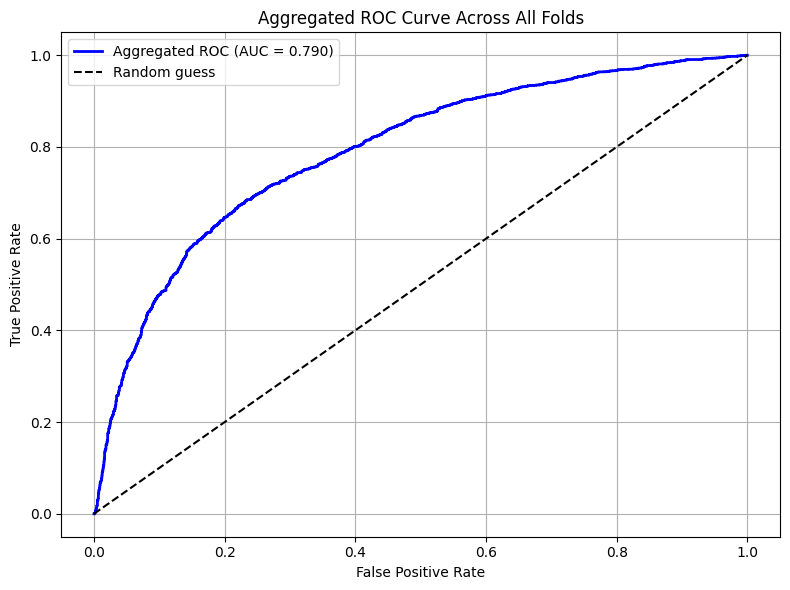

F1-SCORE (Class 0.0): 0.6541 ± 0.0205
F1-SCORE (Class 1.0): 0.7632 ± 0.0083
F1-SCORE (Class macro avg): 0.7086 ± 0.0128
Accuracy: 0.7191 ± 0.0109


####### Processing 100D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.61      0.67      0.64       381
         1.0       0.76      0.70      0.73       558

    accuracy                           0.69       939
   macro avg       0.68      0.69      0.68       939
weighted avg       0.70      0.69      0.69       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       381
         1.0       0.77      0.76      0.77       558

    accuracy                           0.73       939
   macro avg       0.72      0.72      0.72       939
weighted avg       0.73      0.73      0.73       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65       381
         1.0       0.76      0.77      0.76       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.68      0.65      0.67       381
         1.0       0.77      0.80      0.78       558

    accuracy                           0.74       939
   macro avg       0.73      0.72      0.72       939
weighted avg       0.73      0.74      0.73       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65       381
         1.0       0.76      0.76      0.76       558

    accuracy                           0.72       939
   macro avg       0.71      0.71      0.71       939
weighted avg       0.72      0.72      0.72       939



 Total training time across 5 folds: 63.66 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6510 ± 0.0240
  recall: 0.6604 ± 0.0122
  f1-score: 0.6552 ± 0.0102
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7654 ± 0.0056
  recall: 0.7570 ± 0.0291
  f1-score: 0.7609 ± 0.0164
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.7082 ± 0.0138
  recall: 0.7087 ± 0.0114
  f1-score: 0.7081 ± 0.0130
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7190 ± 0.0120
  recall: 0.7178 ± 0.

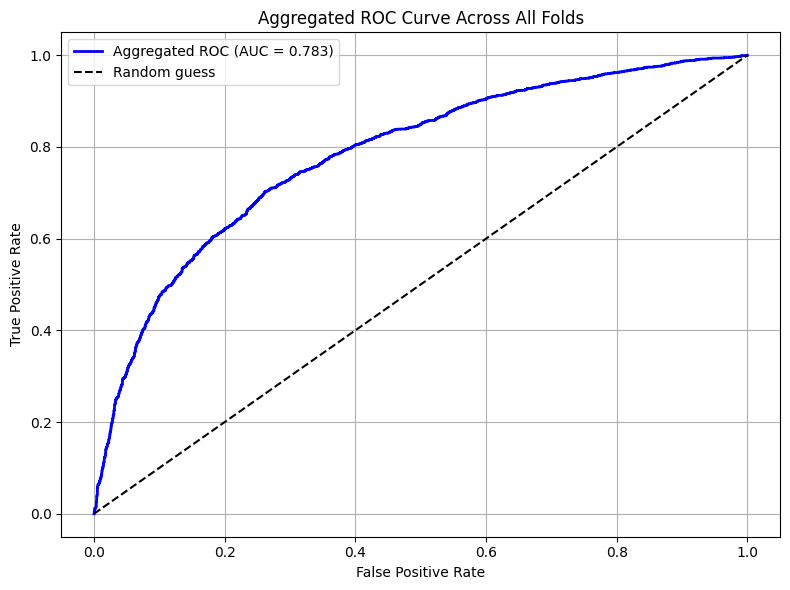

F1-SCORE (Class 0.0): 0.6552 ± 0.0102
F1-SCORE (Class 1.0): 0.7609 ± 0.0164
F1-SCORE (Class macro avg): 0.7081 ± 0.0130
Accuracy: 0.7178 ± 0.0145


####### Processing 300D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.62      0.67      0.64       381
         1.0       0.76      0.71      0.74       558

    accuracy                           0.70       939
   macro avg       0.69      0.69      0.69       939
weighted avg       0.70      0.70      0.70       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63       381
         1.0       0.75      0.71      0.73       558

    accuracy                           0.69       939
   macro avg       0.68      0.69      0.68       939
weighted avg       0.69      0.69      0.69       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64       381
         1.0       0.75      0.74      0.75       558

    accuracy                           0.70       939
   macro avg       0.69      0.69      0.69       939
weighted avg       0.70      0.70      0.70       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62       381
         1.0       0.74      0.76      0.75       558

    accuracy                           0.70       939
   macro avg       0.68      0.68      0.68       939
weighted avg       0.69      0.70      0.69       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64       381
         1.0       0.76      0.76      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939



 Total training time across 5 folds: 62.61 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6253 ± 0.0123
  recall: 0.6451 ± 0.0217
  f1-score: 0.6347 ± 0.0091
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7524 ± 0.0076
  recall: 0.7355 ± 0.0201
  f1-score: 0.7436 ± 0.0088
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.6888 ± 0.0066
  recall: 0.6903 ± 0.0064
  f1-score: 0.6892 ± 0.0066
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.7008 ± 0.0061
  recall: 0.6988 ± 0.

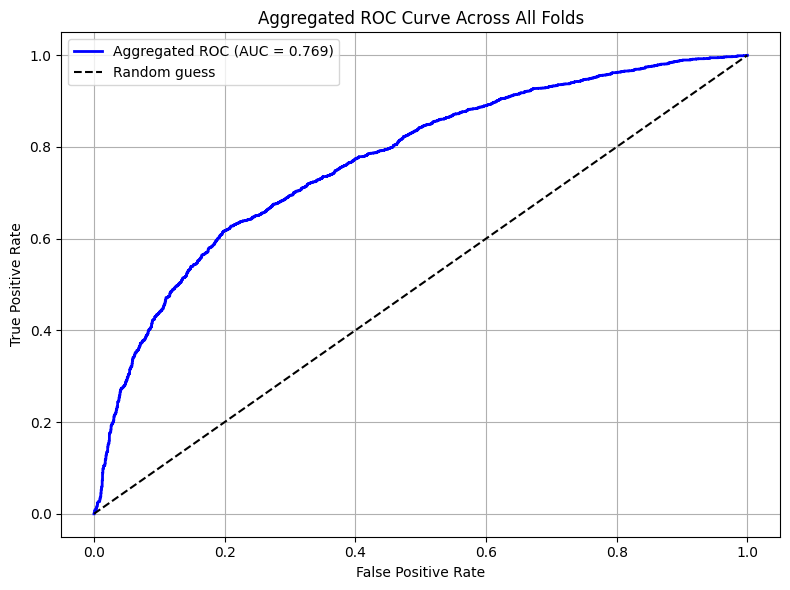

F1-SCORE (Class 0.0): 0.6347 ± 0.0091
F1-SCORE (Class 1.0): 0.7436 ± 0.0088
F1-SCORE (Class macro avg): 0.6892 ± 0.0066
Accuracy: 0.6988 ± 0.0070


####### Processing 512D WITH SMOTE #######


@@@@@@@@ Running 5-Fold Cross Validation with external test set @@@@@@@@


--- Fold 1/5 ---



Classification report for fold 1:

              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65       381
         1.0       0.76      0.75      0.76       558

    accuracy                           0.71       939
   macro avg       0.70      0.70      0.70       939
weighted avg       0.71      0.71      0.71       939


--- Fold 2/5 ---



Classification report for fold 2:

              precision    recall  f1-score   support

         0.0       0.63      0.64      0.64       381
         1.0       0.75      0.75      0.75       558

    accuracy                           0.70       939
   macro avg       0.69      0.69      0.69       939
weighted avg       0.70      0.70      0.70       939


--- Fold 3/5 ---



Classification report for fold 3:

              precision    recall  f1-score   support

         0.0       0.61      0.65      0.63       381
         1.0       0.75      0.72      0.73       558

    accuracy                           0.69       939
   macro avg       0.68      0.68      0.68       939
weighted avg       0.69      0.69      0.69       939


--- Fold 4/5 ---



Classification report for fold 4:

              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63       381
         1.0       0.75      0.70      0.72       558

    accuracy                           0.68       939
   macro avg       0.67      0.68      0.68       939
weighted avg       0.69      0.68      0.68       939


--- Fold 5/5 ---



Classification report for fold 5:

              precision    recall  f1-score   support

         0.0       0.61      0.66      0.63       381
         1.0       0.75      0.71      0.73       558

    accuracy                           0.69       939
   macro avg       0.68      0.68      0.68       939
weighted avg       0.69      0.69      0.69       939



 Total training time across 5 folds: 60.17 seconds (0.02 hours)
Approximate GPU usage: 0.02 GPU hours (using 1 GPU(s))


Aggregated metrics across folds:

Class/Average: 0.0
  precision: 0.6185 ± 0.0164
  recall: 0.6520 ± 0.0082
  f1-score: 0.6346 ± 0.0068
  support: 381.0000 ± 0.0000

Class/Average: 1.0
  precision: 0.7530 ± 0.0037
  recall: 0.7247 ± 0.0214
  f1-score: 0.7385 ± 0.0122
  support: 558.0000 ± 0.0000

Class/Average: macro avg
  precision: 0.6858 ± 0.0096
  recall: 0.6883 ± 0.0082
  f1-score: 0.6865 ± 0.0093
  support: 939.0000 ± 0.0000

Class/Average: weighted avg
  precision: 0.6984 ± 0.0083
  recall: 0.6952 ± 0.

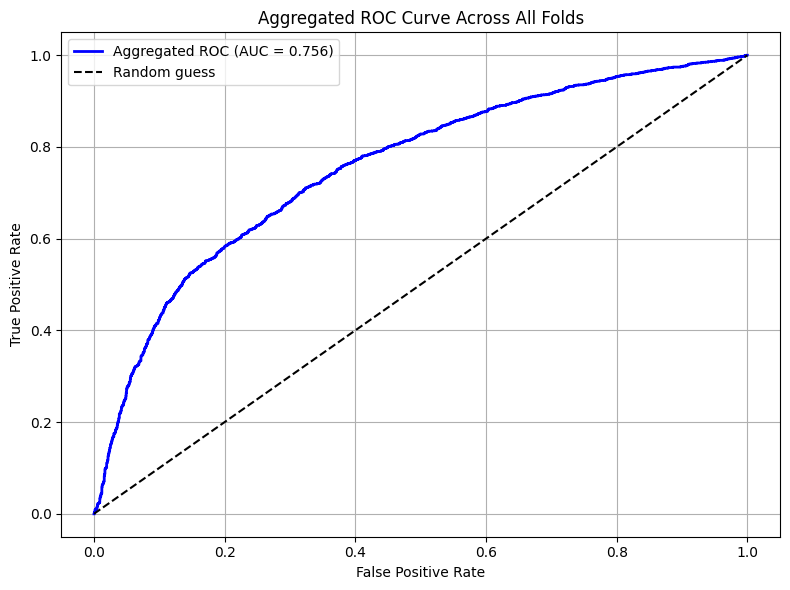

F1-SCORE (Class 0.0): 0.6346 ± 0.0068
F1-SCORE (Class 1.0): 0.7385 ± 0.0122
F1-SCORE (Class macro avg): 0.6865 ± 0.0093
Accuracy: 0.6952 ± 0.0105


In [34]:
# ---- With SMOTE ----
for dim in embedding_dims:
    print(f"\n\n####### Processing {dim}D WITH SMOTE #######\n")
    X = np.array(eval(f"train_embeddings_{dim}"))
    y = np.array(labels_train)
    sm = SMOTE(random_state=dim)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    X_test_ext = np.array(eval(f"test_embeddings_{dim}"))
    y_test_ext = np.array(labels_test)

    reports, (y_true, y_prob), _, train_time = stratified_fold_cv(
        X_resampled, y_resampled, X_test_ext, y_test_ext,
        smote=False,  # Already applied manually
        k=5,
        verbose=False,
        return_fold_roc=True,
        num_gpus=1
    )

    # Save for plotting separately if you want
    all_ytrue_yprob[f"Dim {dim} (SMOTE)"] = (y_true, y_prob)

    # Extract stats
    f1_0 = analyze_results(reports, metric='f1-score', cls=0.0)
    f1_1 = analyze_results(reports, metric='f1-score', cls=1.0)
    macro_f1 = analyze_results(reports, metric='f1-score', cls='macro avg')
    acc = analyze_accuracy(reports)
    auc_val = roc_auc_score(y_true, y_prob)
    
    results_summary.append({
    "Model": f"MLP ({dim}d, SMOTE)",
    "Accuracy": f"{np.mean(acc):.4f} ± {mean_confidence_interval(acc)[1]:.4f}",
    "F1_0": f"{np.mean(f1_0):.4f} ± {mean_confidence_interval(f1_0)[1]:.4f}",
    "F1_1": f"{np.mean(f1_1):.4f} ± {mean_confidence_interval(f1_1)[1]:.4f}",
    "Macro_F1": f"{np.mean(macro_f1):.4f} ± {mean_confidence_interval(macro_f1)[1]:.4f}",
    "ROC_AUC": f"{auc_val:.4f}",
    "Total Time (s)": f"{train_time:.4f}",
    "SMOTE": "Yes"
})



In [35]:
# === Final Table ===
df = pd.DataFrame(results_summary)
df = df[["Model", "Accuracy", "F1_0", "F1_1", "Macro_F1", "ROC_AUC", "Total Time (s)", "SMOTE"]]
print("\n\nFinal Performance Summary Table:\n")
df





Final Performance Summary Table:



,Model,Accuracy,F1_0,F1_1,Macro_F1,ROC_AUC,Total Time (s),SMOTE
0,MLP (50d),0.7152 ± 0.0030,0.6095 ± 0.0133,0.7757 ± 0.0044,0.6926 ± 0.0056,0.7765,49.1183,No
1,MLP (100d),0.6999 ± 0.0097,0.5958 ± 0.0270,0.7610 ± 0.0057,0.6784 ± 0.0146,0.7675,40.7753,No
2,MLP (300d),0.6952 ± 0.0076,0.5797 ± 0.0153,0.7608 ± 0.0064,0.6702 ± 0.0092,0.7592,44.0480,No
3,MLP (512d),0.6990 ± 0.0046,0.5999 ± 0.0177,0.7585 ± 0.0060,0.6792 ± 0.0077,0.7521,42.8260,No
4,"MLP (50d, SMOTE)",0.7191 ± 0.0109,0.6541 ± 0.0205,0.7632 ± 0.0083,0.7086 ± 0.0128,0.7903,62.9410,Yes
5,"MLP (100d, SMOTE)",0.7178 ± 0.0145,0.6552 ± 0.0102,0.7609 ± 0.0164,0.7081 ± 0.0130,0.7830,63.6639,Yes
6,"MLP (300d, SMOTE)",0.6988 ± 0.0070,0.6347 ± 0.0091,0.7436 ± 0.0088,0.6892 ± 0.0066,0.7689,62.6103,Yes
7,"MLP (512d, SMOTE)",0.6952 ± 0.0105,0.6346 ± 0.0068,0.7385 ± 0.0122,0.6865 ± 0.0093,0.7558,60.1664,Yes


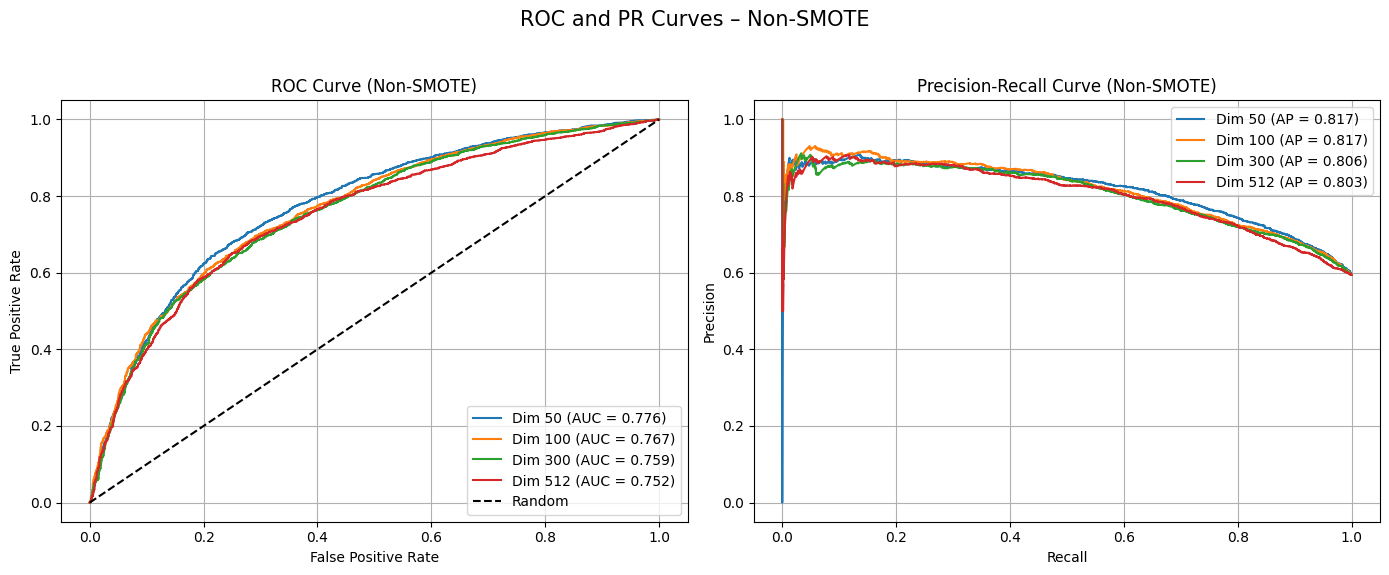

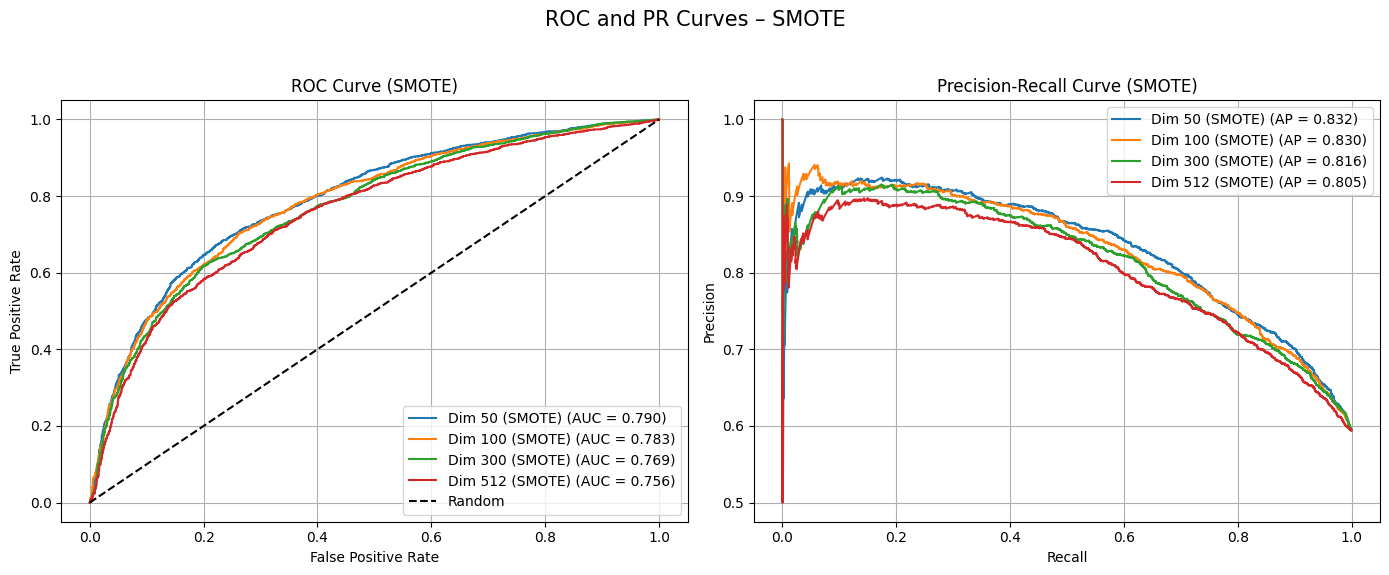

In [36]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


non_smote_dict = {k: v for k, v in all_ytrue_yprob.items() if "SMOTE" not in k}
smote_dict = {k: v for k, v in all_ytrue_yprob.items() if "SMOTE" in k}

# Define the plotting function
def plot_roc_pr_group(data_dict, group_name="Group"):
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(14, 6))

    for label, (y_true, y_score) in data_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc_val = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_val:.3f})')

        precision, recall, _ = precision_recall_curve(y_true, y_score)
        ap_val = average_precision_score(y_true, y_score)
        ax_pr.plot(recall, precision, label=f'{label} (AP = {ap_val:.3f})')

    # ROC plot settings
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Random')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC Curve ({group_name})')
    ax_roc.legend()
    ax_roc.grid(True)

    # PR plot settings
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title(f'Precision-Recall Curve ({group_name})')
    ax_pr.legend()
    ax_pr.grid(True)

    plt.suptitle(f'ROC and PR Curves – {group_name}', fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot both groups
plot_roc_pr_group(non_smote_dict, group_name="Non-SMOTE")
plot_roc_pr_group(smote_dict, group_name="SMOTE")
